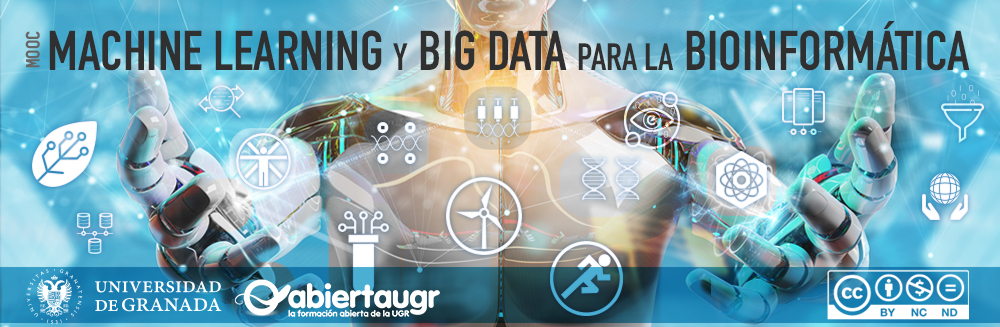

## **Módulo 6 - Aprendizaje No Supervisado: Clustering y Reglas de Asociación**
## **6.3 Métodos Clásicos de Reglas de Asociación (RAs)**

**Autores**: 

*Por* Elena Ruiz Sánchez

Desarrolladora en PerkinElmer y Miembro del Instituto Andaluz Interuniversitario en Data Science and Computational Intelligence (DasCI)

*Por* Dr. Jesús Alcalá Fernández


Profesor Titular en CCIA de Universidad de Granada y Miembro del Instituto Andaluz Interuniversitario en Data Science and Computational Intelligence (DasCI)

**Recordatorio: Introducción a NoteBook**

Dentro de este cuaderno (*NoteBook*), se le guiará paso a paso desde la carga de un conjunto de datos hasta el análisis descriptivo de su contenido.

El cuaderno de *Jupyter* (Python) es un enfoque que combina bloques de texto (como éste) junto con bloques o celdas de código. La gran ventaja de este tipo de celdas, es su interactividad, ya que pueden ser ejecutadas para comprobar los resultados directamente sobre las mismas. *Muy importante*: el orden las instrucciones es fundamental, por lo que cada celda de este cuaderno debe ser ejecutada secuencialmente. En caso de omitir alguna, puede que el programa lance un error, así que se deberá comenzar desde el principio en caso de duda.

Antes de nada:

Es muy muy importante que al comienzo se seleccione "*Abrir en modo de ensayo*" (draft mode), arriba a la izquierda. En caso contrario, no permitirá ejecutar ningún bloque de código, por cuestiones de seguridad. Cuando se ejecute el primero de los bloques, aparecerá el siguiente mensaje: "*Advertencia: Este cuaderno no lo ha creado Google.*". No se preocupe, deberá confiar en el contenido del cuaderno (*NoteBook*) y pulsar en "Ejecutar de todos modos".

¡Ánimo!

Haga clic en el botón "play" en la parte izquierda de cada celda de código. Las líneas que comienzan con un hashtag (#) son comentarios y no afectan a la ejecución del programa.

También puede pinchar sobre cada celda y hacer "*ctrl+enter*" (*cmd+enter* en Mac).

Cada vez que ejecute un bloque, verá la salida justo debajo del mismo. La información suele ser siempre la relativa a la última instrucción, junto con todos los `print()` (orden para imprimir) que haya en el código.

## **ÍNDICE**


En este *notebook*: 
1. Descubrimos ejemplos de variables que podemos utilizar para extraer asociaciones y aprender más sobre distintos grupos de pacientes.
2. Aprendemos a transformar nuestro conjunto de datos en un conjunto de transacciones.
3. Vemos cómo decidir los umbrales de soporte y confianza para nuestro problema apoyándonos en el uso de gráficos.
4. Descubrimos cómo utilizar la biblioteca [*MLXTEND*](http://rasbt.github.io/mlxtend/) para extraer itemsets frecuentes y reglas de asociación.
5. Estudiamos distintas formas de analizar nuestras reglas apoyándonos en distintos tipos de gráficos.
    
Contenidos:
1. Descripción del problema
2. Leer y procesar los datos
3. Obtención de itemsets frecuentes
4. Extracción y análisis de reglas de asociación

## **INSTALACIÓN DE LIBRERÍAS**

In [ ]:
# Instalar la biblioteca mlxtend
!pip install --upgrade mlxtend # El signo de exclamación ! es necesario porque estamos usando un notebook
#pip install --upgrade mlxtend # Usa esta línea si quieres instalar mlxtend fuera de un notebook

     |████████████████████████████████| 1.4MB 7.2MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
# Instalamos la biblioteca rpy2 para combinar R y Python
#!apt-get update
#!apt-get install r-base
!pip install rpy2
# Cargamos la extensión rpy2.ipython
%load_ext rpy2.ipython

In [ ]:
# Instalar librerías de R que necesitaremos más adelante
%%R
# Instalamos la biblioteca chorddiag desde un repositorio de GitHub
devtools::install_github("mattflor/chorddiag")
# Instalamos la biblioteca RColorBrewer que nos permite utilizar distintas
# paletas de colores de forma sencilla
install.packages('RColorBrewer')

R[write to console]: Downloading GitHub repo mattflor/chorddiag@HEAD



✔  checking for file ‘/tmp/Rtmpb2wjz7/remotes3b5e37eed5/mattflor-chorddiag-1688d72/DESCRIPTION’ (336ms)
─  preparing ‘chorddiag’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘chorddiag_0.1.3.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/RColorBrewer_1.1-2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 11532 bytes (11 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

##**1. INTRODUCCIÓN AL PROBLEMA<a id="sec:intro"></a>**

Ya hemos visto cómo, incluso partiendo de un mismo problema, podemos aplicar distintas técnicas de Machine Learning dependiendo del tipo de tarea que nos interese resolver. En la cápsula anterior hemos visto que es posible utilizar clustering para formar distintos grupos de pacientes en base a la información de expresión genética. Los autores del estudio original realizaron un análisis clustering de este tipo llegando a obtener tres grupos de pacientes que se comprobó mostraban tiempos de supervivencia significativamente distintos. En esta cápsula vamos a centrarnos en utilizar la extracción de reglas de asociación para complementar la información sobre estos grupos de pacientes y caracterizar potenciales subgrupos.

Para ello vamos a utilizar otros datos, distintos a la expresión genética, para obtener más información sobre las características de los pacientes incluidos en cada uno de los grupos y comprobar si las diferencias en la expresión de ciertos genes va de la mano de diferencias también en otras variables. Conocer si existen estas posibles conexiones entre variables y saber cuáles son nos ayuda a comprender mejor la enfermedad y puede llevar a identificar relaciones desconocidas que sirvan de base a nuevas hipótesis para mejorar la prevención, detección o tratamiento de dicha enfermedad.

Concretamente, vamos a trabajar con seis variables distintas. Una de ellas indica el cluster en el que fue incluida la instancia en base a los niveles de expresión genética, mientras que las otras cinco son variables que nos pueden aportar información adicional sobre las características del tipo de pacientes incluido en cada cluster. Estas variables son:

*   MUTATIONSUBTYPES: un importante logro en la práctica clínica ha sido el desarrollo de terapias dirigidas para pacientes que presentan determinadas mutaciones. Por lo tanto, es interesante conocer para cada melanoma si se han encontrado mutaciones significativas en determinados genes. Esta variable indica para cada instancia si se ha encontrado alguno de los tipos de mutaciones más frecuentes entre los pacientes analizados. Tiene 4 valores posibles: 
  * *BRAF_Hotspot_Mutants*: hay presencia de mutaciones del tipo BRAF hot-spot. Este tipo de mutaciones es el más frecuente en el conjunto de datos, se encuentra en un 52% de las instancias.
  * *RAS_Hotspot_Mutants*: indica presencia de mutaciones RAS hot-spot. Es el segundo tipo de mutación que en más instancias se encuentra. 
  * *NF1_Any_Mutants*: el tercer tipo de mutación más frecuentemente observado es mutación del gen NF1, presente en un 14% de las instancias. 
  * *Triple_WT*: este subtipo Triple_WT se define como un grupo heterogéneo en el que se incluyen aquellas instancias en las que no hay ni mutaciones BRAF, ni RAS, ni NF1.
*   UV-signature: la radiación ultravioleta juega un papel mutagénico importante en el melanoma. Esta variable tiene dos posibles valores: *UV signature* o *not UV*. Están marcadas con el valor *UV signature* aquellas instancias para las que las transiciones C>T representan más del 60% o las mutaciones CC>TT suponen más del 5% de la carga total de mutaciones. Las instancias que no cumplan esa condición tienen el valor *not UV*.
*   RNASEQ-CLUSTER_CONSENHIER: indica el cluster que se ha asignado a la instancia en el proceso de clustering que hemos visto en la cápsula anterior y cuyos resultados vamos a intentar complementar gracias al empleo de reglas de asociación. Toma tres valores distintos, cada uno de ellos representa a uno de los posibles clusters: *immune*, *keratin* y *MITF-low*.
*   MethTypes.201408: esta variable es también resultado de un proceso de clustering, en este caso aplicado sobre los valores de metilación para una serie de GpC locus. Al igual que en el caso anterior, cada uno de los valores se corresponden con un cluster. En este caso son 4 los clusters existentes: *CpG island-methylated*, *hyper-methylated*, *normal-like* e *hypo-methylated*. Siendo las instancias del cluster *CpG island-methylated* las que presentan niveles de metilación altos para un mayor número de CpG locus, y las del clúster *hypo-methylated* las que presentan los valores más bajos de metilación. 
*   MIRCluster: como su propio nombre señala, se trata de una tercera variable resultado de un proceso de clustering. Esta vez aplicado sobre datos de secuenciación de microRNA. Son cuatro los posibles clusters nombrados como: *MIR.type.1*, *MIR.type.2*, *MIR.type.3* y *MIR.type.4*.
*   LYMPHOCYTE.SCORE: esta medida se calcula en función de la distribución y densidad de linfocitos. Ambos factores (distribución y densidad) son evaluados por expertos y puntuados en una escala [0-3], indicando el 0 ausencia de linfocitos en ambos casos y el 3 presencia de linfocitos en la mayor parte del tejido (distribución) o alta concentración (en el caso de la densidad). LYMPHOCYTE.SCORE se calcula como la suma de ambas puntuaciones y, por tanto, toma valores enteros en el rango [0,6].

Este es el enfoque del análisis que vamos a llevar a cabo en esta cápsula. No obstante, el uso de reglas de asociación podría ser de utilidad en otros enfoques dentro del contexto de cáncer de melanoma con el que se está trabajando a lo largo del curso.
El grupo de variables con las que trabajar, al igual que la técnica a escoger, va a depender de cuál sea nuestro objetivo y de las características que presenten las variables en cuestión.

Nosotros vamos a centrarnos en las 6 variables mencionadas y llevaremos a cabo los pasos necesarios para identificar los itemsets frecuentes, extraer las reglas de asociación y analizarlas. Como parte de ese último paso realizaremos un análisis por grupos de las reglas centrándonos en ciertas variables que nos resultan de interés. Por ejemplo, estudiaremos reglas en las que aparecen ciertos subtipos de mutaciones y veremos qué conclusiones podemos extraer sobre cómo se relacionan esos tipos de mutación con el resto de variables.

##**2. LEER Y PROCESAR LOS DATOS<a id="sec:leer"></a>**

###**2.1 Lectura del conjunto de datos**

El primer paso es leer nuestro conjunto de datos para poder trabajar con él en Python. Para leer el archivo vamos a utilizar la biblioteca Pandas.

In [ ]:
# Importamos la biblioteca pandas con el alias 'pd'
import pandas as pd

# Almacenamos el enlace a nuestros datos en la variable 'url_datos'
url_datos = 'https://drive.google.com/uc?id=1VF3MqQ3J7GBc527ClL2IgJ23XTc5-hX7'

# El método read_csv permite leer un archivo en formato CSV
conjunto_datos = pd.read_csv(url_datos, delimiter=',', na_values='-')

# Mostramos las columnas (variables) que hemos leído
print('Variables leídas:')
print(', '.join(conjunto_datos.columns))

Variables leídas:
MUTATIONSUBTYPES, UV-signature, RNASEQ-CLUSTER_CONSENHIER, MethTypes.201408, MIRCluster, LYMPHOCYTE.SCORE


El conjunto de datos leído es parte de uno de los archivos con datos publicados por los autores del estudio original. El archivo publicado por los autores recoge muchas más variables, además de las seis que vamos a utilizar en este notebook.

###**2.2 Transformación en conjunto de transacciones**

Este conjunto de datos contiene un número fijo de variables (6 variables) y cada una de las instancias (que se corresponde con una muestra de tejido de un paciente determinado) contiene un valor para cada una de esas variables.

Echamos un vistazo a las primeras instancias de nuestro conjunto de datos para comprobarlo:

In [ ]:
# Para poder ver en pantalla todas las variables
pd.set_option('display.max_columns', 6) 
print('Primeras 5 instancias del conjunto de datos:') 
# Mostrar las primeras 5 instancias del conjunto de datos
print(conjunto_datos.head())
# Para volver al valor por defecto
pd.reset_option('display.max_columns') 

Primeras 5 instancias del conjunto de datos:
       MUTATIONSUBTYPES  UV-signature RNASEQ-CLUSTER_CONSENHIER  \
0  BRAF_Hotspot_Mutants  UV signature                   keratin   
1   RAS_Hotspot_Mutants  UV signature                   keratin   
2  BRAF_Hotspot_Mutants  UV signature                   keratin   
3   RAS_Hotspot_Mutants  UV signature                   keratin   
4             Triple_WT        not UV                    immune   

        MethTypes.201408  MIRCluster  LYMPHOCYTE.SCORE  
0            normal-like  MIR.type.3               2.0  
1  CpG island-methylated  MIR.type.2               4.0  
2            normal-like  MIR.type.1               5.0  
3        hypo-methylated  MIR.type.2               2.0  
4  CpG island-methylated  MIR.type.2               6.0  


Las reglas de asociación surgieron originalmente para tratar con variables categóricas (se ha comprado o no un determinado producto del supermercado). Sin embargo, existen formas de poder incorporar variables numéricas a nuestros análisis con reglas de asociación, por ejemplo, dividiendo los valores de la variable en intervalos, asignándoles un nombre (alto, medio, bajo) y tratando estos intervalos como categorías. De hecho, si la variable numérica puede tomar solo unos pocos valores podemos, directamente, tratar cada uno de estos valores como una categoría. Es el caso de lo que ocurre con la variable LYMPHOCYTE.SCORE.

In [ ]:
print('Distintos valores existentes para cada una de las variables:\n')
for col in conjunto_datos.columns:
  print('*%s-> %s' % (col, ', '.join(conjunto_datos.loc[conjunto_datos[col].notnull(), col].sort_values().unique().astype(str))))


Distintos valores existentes para cada una de las variables:

*MUTATIONSUBTYPES-> BRAF_Hotspot_Mutants, NF1_Any_Mutants, RAS_Hotspot_Mutants, Triple_WT
*UV-signature-> UV signature, not UV
*RNASEQ-CLUSTER_CONSENHIER-> MITF-low, immune, keratin
*MethTypes.201408-> CpG island-methylated, hyper-methylated, hypo-methylated, normal-like
*MIRCluster-> MIR.type.1, MIR.type.2, MIR.type.3, MIR.type.4
*LYMPHOCYTE.SCORE-> 0.0, 2.0, 3.0, 4.0, 5.0, 6.0


La variable LYMPHOCYTE.SCORE solo tiene 6 posibles valores por lo que vamos a tratar cada uno de ellos como una categoría, al igual que hacemos con los valores de las demás variables.

Hemos visto anteriormente en el curso, que en el ámbito de reglas de asociación lo común es trabajar con ítems y transacciones. Para trabajar con nuestro conjunto de datos en términos de ítems y transacciones necesitamos realizar un pequeño cambio en su formato. 
En este caso, un ítem será un par (variable, valor) y cada instancia será una transacción que contiene una lista de pares (variable, valor).

Para representar este conjunto de transacciones cuando trabajemos en Python tendremos una tabla en la que existe una columna por cada posible ítem y cada fila toma el valor 1 para aquellos ítems (columnas) que sí estén contenidos en la transacción y 0 para los que no.

In [ ]:
# Usamos el método get_dummies de pandas para convertir el conjunto de datos a
# formato transaccional
transacciones = pd.get_dummies(conjunto_datos, columns=conjunto_datos.columns, prefix_sep='=') # Ignora los valores perdidos a no ser que se le indique dummy_na=True

# En el conjunto de transacciones generado por get_dummies cada par 
# (variable, valor) está representado en el formato variable=valor
transacciones.head()

,MUTATIONSUBTYPES=BRAF_Hotspot_Mutants,MUTATIONSUBTYPES=NF1_Any_Mutants,MUTATIONSUBTYPES=RAS_Hotspot_Mutants,MUTATIONSUBTYPES=Triple_WT,UV-signature=UV signature,UV-signature=not UV,RNASEQ-CLUSTER_CONSENHIER=MITF-low,RNASEQ-CLUSTER_CONSENHIER=immune,RNASEQ-CLUSTER_CONSENHIER=keratin,MethTypes.201408=CpG island-methylated,MethTypes.201408=hyper-methylated,MethTypes.201408=hypo-methylated,MethTypes.201408=normal-like,MIRCluster=MIR.type.1,MIRCluster=MIR.type.2,MIRCluster=MIR.type.3,MIRCluster=MIR.type.4,LYMPHOCYTE.SCORE=0.0,LYMPHOCYTE.SCORE=2.0,LYMPHOCYTE.SCORE=3.0,LYMPHOCYTE.SCORE=4.0,LYMPHOCYTE.SCORE=5.0,LYMPHOCYTE.SCORE=6.0
0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


Ya tenemos nuestro conjunto de datos en un formato en el que podemos trabajar sobre ítems y transacciones. Este formato es el que vamos a utilizar como información de entrada para los algoritmos encargados de descubrir itemsets frecuentes.

Los ítems están representados en formato variable=valor para que los itemsets y reglas que generemos en los siguientes pasos sean más fácilmente legibles.

##**3. OBTENCIÓN DE ITEMSETS FRECUENTES<a id="sec:freq_itemsets"></a>**

###**3.1 Explorar los ítems**

El siguiente paso hacia la extracción de reglas de asociación es la identificación de itemsets frecuentes. El soporte mínimo para decidir si un itemset se considera frecuente debemos especificarlo nosotros. Para tener una idea orientativa podemos decir que normalmente el soporte que elijamos se moverá en el rango (0, 0,2], pero este valor puede variar bastante dependiendo de los datos con los que trabajemos. Conocer la frecuencia con la que aparece cada uno de los ítems en el conjunto de datos puede guiarnos un poco más a la hora de escoger el soporte. Aún así, es probable que tengamos que hacer algunas pruebas con distintos valores antes de decantarnos por una opción.

Si necesitas refrescar conceptos como el de itemset frecuente o soporte, recuerda que puedes consultar en cualquier momento tanto la Cápsula 1 de este módulo como la Cápsula 3 del Módulo 3.

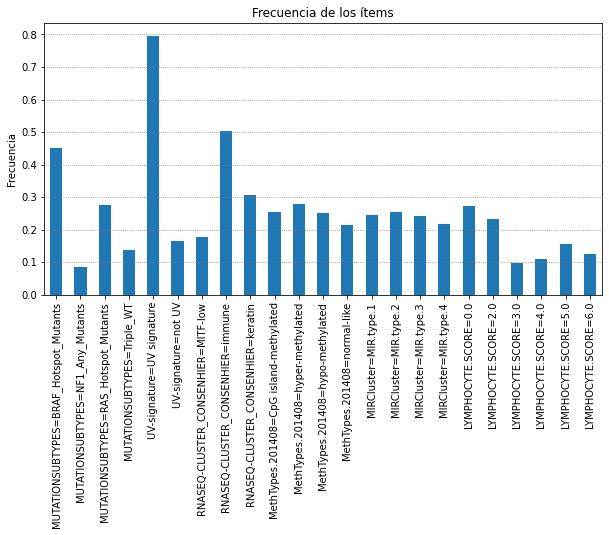

In [ ]:
# Importamos la biblioteca matplotlib.pyplot con el alias plt
# Esta biblioteca nos permite generar gráficos de distinto tipo
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
# Calculamos la frecuencia de cada ítem dividiendo el nº de unos (suma) en la 
# columna correspondiente entre el nº total de transacciones (filas)
item_freqs = transacciones.sum()/len(transacciones)
# Representamos dichas frecuencias en un gráfico de barras
item_freqs.plot(kind='bar', title='Frecuencia de los ítems')
plt.ylabel('Frecuencia')
plt.grid(axis='y', ls=':', color='grey')
plt.show()

Observamos que hay un número significativo de ítems con una frecuencia inferior a 0,2. Llegando los ítems menos frecuentes a tener un soporte por debajo de 0,1.
Es importante comprender el significado del soporte y tener en cuenta las frecuencias de los ítems dentro de nuestro conjunto de datos a la hora de decidir un umbral de soporte mínimo. Si en este caso fijásemos un umbral de soporte de 0,2 sabemos que automáticamente todos los ítems que aparecen en menos del 20% de las transacciones quedan descartados como itemsets frecuentes. Y, por tanto, también queda descartado como itemset frecuente cualquier superconjunto que pudiera incluirlos, y no podrá generarse ninguna regla que incluya dicho ítem.

Por poner un ejemplo, si el item LYMPHOCYTE.SCORE=5.0 con un soporte de  0,1561 no es un itemset frecuente tampoco puede serlo (LYMPHOCYTE.SCORE=5.0, RNASEQ-CLUSTER_CONSENHIER=immune) ni ningún otro itemset que incluya el ítem LYMPHOCYTE.SCORE=5.0, puesto que cualquiera de estos otros itemsets puede aparecer en el conjunto de datos, como máximo, tantas veces como aparece LYMPHOCYTE.SCORE=5.0.

In [ ]:
print('Frecuencia de cada uno de los ítems:')
print(transacciones.sum()/len(transacciones))

Frecuencia de cada uno de los ítems:
MUTATIONSUBTYPES=BRAF_Hotspot_Mutants     0.450450
MUTATIONSUBTYPES=NF1_Any_Mutants          0.084084
MUTATIONSUBTYPES=RAS_Hotspot_Mutants      0.276276
MUTATIONSUBTYPES=Triple_WT                0.138138
UV-signature=UV signature                 0.795796
UV-signature=not UV                       0.165165
RNASEQ-CLUSTER_CONSENHIER=MITF-low        0.177177
RNASEQ-CLUSTER_CONSENHIER=immune          0.504505
RNASEQ-CLUSTER_CONSENHIER=keratin         0.306306
MethTypes.201408=CpG island-methylated    0.255255
MethTypes.201408=hyper-methylated         0.279279
MethTypes.201408=hypo-methylated          0.252252
MethTypes.201408=normal-like              0.213213
MIRCluster=MIR.type.1                     0.246246
MIRCluster=MIR.type.2                     0.255255
MIRCluster=MIR.type.3                     0.243243
MIRCluster=MIR.type.4                     0.216216
LYMPHOCYTE.SCORE=0.0                      0.273273
LYMPHOCYTE.SCORE=2.0                      0.2

En esta cápsula vamos a trabajar con un soporte mínimo de 0,015. Se trata de un soporte lo suficientemente bajo como para que todos los ítems básicos (1-itemsets) sean considerados frecuentes y, por tanto, tengan la posibilidad de formar parte de alguna regla de asociación. También es lo suficiemente bajo como para permitir cierta diversidad en itemsets más largos. Al mismo tiempo, este soporte mínimo permite que no se consideren itemsets frecuentes aquellos conjuntos de ítems que representen casos excesivamente particulares como, por ejemplo, aquellos que se den para una sola transacción (un solo paciente).

Te animamos a experimentar con distintos umbrales de soporte y comprobar cómo varía el número, longitud y contenido de los itemsets considerados frecuentes y de las reglas extraídas a partir de ellos.

###**3.2 El algoritmo FP-Growth para detección de itemsets frecuentes**

**FP-Growth** es un algoritmo para identificar los itemsets frecuentes en un conjunto de datos dado un soporte mínimo. La principal ventaja de FP-Growth es su eficiencia. Utiliza una estructura de árbol para representar el conjunto de datos de forma comprimida y esto le permite ser más eficiente encontrando los itemsets frecuentes que otras técnicas.

Para aplicar FP-Growth vamos a utilizar la biblioteca [MLXTEND](http://rasbt.github.io/mlxtend/). MLXTEND es una biblioteca de Python que incluye herramientas de ciencia de datos y Machine Learning. 
No se limita a extracción de reglas de asociación sino que incluye distintos tipos de métodos. Sin embargo, en esta cápsula nos vamos a centrar en la funcionalidad que ofrece para [itemsets frecuentes y reglas de asociación](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/).

Entre otras opciones MLXTEND incluye una implementación del algoritmo [FP-Growth](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/).

In [ ]:
# Importamos FP-Growth desde MLXTEND
from mlxtend.frequent_patterns import fpgrowth

# Aplicamos FP-growth indicándole el umbral de soporte mínimo para considerar 
# frecuente un itemset
# Con el parámetro 'max_len' indicamos la longitud máxima de los itemsets
itemsets_frecuentes = fpgrowth(transacciones, min_support=0.015, use_colnames=True, max_len=4)

print('%d itemsets frecuentes identificados.' % (len(itemsets_frecuentes)))

965 itemsets frecuentes identificados.


Además de especificar el umbral de soporte mínimo, también hemos indicado una longitud máxima de 4 ítems para los itemsets. Limitar la longitud máxima de los itemsets permite que las reglas sean menos complejas y su análisis sea algo más sencillo.
Podemos echar un vistazo al contenido de *itemsets_frecuentes* para comprobar el formato de la salida que nos ha devuelto FP-Growth.

In [ ]:
# Mostramos las primeras 5 filas de freq_itemsets
print(itemsets_frecuentes.head())

    support                                 itemsets
0  0.795796              (UV-signature=UV signature)
1  0.450450  (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants)
2  0.306306      (RNASEQ-CLUSTER_CONSENHIER=keratin)
3  0.243243                  (MIRCluster=MIR.type.3)
4  0.231231                   (LYMPHOCYTE.SCORE=2.0)


Como vemos *itemsets_frecuentes* tiene dos columnas: la primera contiene el soporte de un itemset frecuente y la segunda presenta al propio itemset frecuente. Viendo solamente estas 5 primeras filas de *itemsets_frecuentes* podríamos pensar que todos los itemsets frecuentes encontrados tienen longitud 1, es decir, están formados por un solo ítem. Sin embargo, si consultamos las 5 últimas filas la cosa cambia.

In [ ]:
# Mostramos las últimas 5 filas de freq_itemsets
print(itemsets_frecuentes.tail())

      support                                           itemsets
960  0.021021  (MIRCluster=MIR.type.2, UV-signature=UV signat...
961  0.021021  (MIRCluster=MIR.type.2, UV-signature=UV signat...
962  0.018018  (RNASEQ-CLUSTER_CONSENHIER=immune, MUTATIONSUB...
963  0.015015  (UV-signature=UV signature, MUTATIONSUBTYPES=N...
964  0.015015  (UV-signature=UV signature, RNASEQ-CLUSTER_CON...


Lo que ocurre es que los itemsets frecuentes están ordenados de forma que los formados por un solo ítem (los que presentan soportes más altos) aparecen en las primeras filas y los más complejos en las últimas. A medida que añadimos ítems a los itemsets el soporte se reduce porque vamos añadiendo más elementos que deben estar al mismo tiempo en la transacción.

Para hacernos mejor una idea general de las longitudes de los itemsets frecuentes identificados por FP-Growth podemos consultar la longitud de cada uno de los itemsets frecuentes, contar cuántos itemsets hay con cada longitud y representarlo gráficamente.

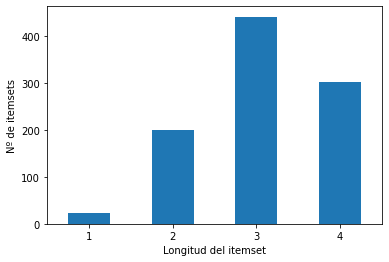

In [ ]:
# Contabilizamos cuántos frequent itemsets se han encontrado con cada longitud
itemsets_frecuentes_por_longitud = itemsets_frecuentes['itemsets'].apply(len).value_counts().sort_index()

# Creamos un gráfico de barras para representar el nº de itemsets según
# el número de ítems que contienen
fig = plt.figure()
ax = fig.add_subplot(111)
itemsets_frecuentes_por_longitud.plot(kind='bar', ax=ax, rot=0)
ax.set_xlabel('Longitud del itemset')
ax.set_ylabel('Nº de itemsets')
plt.show()

##**4. EXTRACCIÓN Y ANÁLISIS DE REGLAS DE ASOCIACIÓN<a id="sec:reglas"></a>**

###**4.1 De itemsets frecuentes a reglas de asociación**

Una vez hemos identificado los itemsets frecuentes gracias al algoritmo FP-Growth, vamos ahora a generar a partir de ellos reglas de asociación con una cierta confianza mínima.
Para ello seguimos trabajando con la biblioteca MLXTEND que también incluye funcionalidad para generar [reglas de asociación](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) a partir de una lista de itemsets frecuentes.
Como umbral de confianza mínima vamos a indicar 0,85. 

El umbral de confianza que elijamos, igual que ocurría con el del soporte, va a depender del problema en el que estemos trabajando. Es normal hacer pruebas con distintos umbrales hasta escoger el que nos parece más apropiado. Normalmente, umbrales de confianza demasiado bajos no van a resultar útiles puesto que se trata de que la implicación A->C que representa la regla se cumpla en la mayoría de las ocasiones en las que aparece A. En general, es conveniente elegir confianzas iguales o superiores a 0,75 para asegurar que la regla se incumple como máximo en el 25% de las ocasiones, lo cual supone un margen de error considerablemente alto. 

In [ ]:
# Importamos el método association_rules de la biblioteca MLXTEND
from mlxtend.frequent_patterns import association_rules

# Indicamos un umbral de confianza mínima para las reglas de 0,85
reglas_asociacion = association_rules(itemsets_frecuentes, metric="confidence", min_threshold=0.85)

print('%d reglas generadas.' % (len(reglas_asociacion)))

317 reglas generadas.


Al igual que hicimos con el resultado de FP-Growth podemos echar un vistazo a *reglas_asociacion*.

In [ ]:
# Para poder ver en pantalla todas las variables
pd.set_option('display.max_columns', 6) 
print('Primeras cinco reglas:')
print(reglas_asociacion.head())
pd.reset_option('display.max_columns')

Primeras cinco reglas:
                                         antecedents  \
0            (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants)   
1  (RNASEQ-CLUSTER_CONSENHIER=immune, MUTATIONSUB...   
2  (RNASEQ-CLUSTER_CONSENHIER=keratin, MUTATIONSU...   
3  (MIRCluster=MIR.type.3, MUTATIONSUBTYPES=BRAF_...   
4  (RNASEQ-CLUSTER_CONSENHIER=keratin, MIRCluster...   

                   consequents  antecedent support  ...      lift  leverage  \
0  (UV-signature=UV signature)            0.450450  ...  1.139321  0.049942   
1  (UV-signature=UV signature)            0.231231  ...  1.158687  0.029200   
2  (UV-signature=UV signature)            0.102102  ...  1.108768  0.008838   
3  (UV-signature=UV signature)            0.084084  ...  1.077089  0.005158   
4  (UV-signature=UV signature)            0.033033  ...  1.142367  0.003742   

   conviction  
0    2.187902  
1    2.620621  
2    1.735736  
3    1.429429  
4    2.246246  

[5 rows x 9 columns]


*reglas_asociacion* tiene 9 columnas y contiene un total de 317 reglas. En cuanto a las columnas, dos de ellas, *antecedents* y *consequents*, están dedicadas a almacenar los dos itemsets que forman el antecedente y consecuente de la regla, respectivamente. Las otras 7 columnas contienen valores para distintas medidas de calidad de la regla.

###**4.2 Comenzar a conocer las reglas extraídas**


El número de reglas encontradas (317) puede resultar un poco abrumador *a priori*. ¿Por dónde empezamos? ¿Cómo sabemos qué reglas pueden ser más interesantes? ¿Qué medida de calidad deberíamos mirar?
Vayamos paso a paso.

Podemos empezar consultando cuántos ítems forman los antecedentes y consecuentes de las reglas obtenidas. Como hemos limitado la longitud de los itemsets frecuentes a un máximo de 4 ítems, el antecedente de las reglas tendrá como mucho 3 ítems puesto que, al menos, uno de ellos tiene que ir al consecuente.

In [ ]:
print('Nº de reglas con cada longitud de antecedente:')
print(reglas_asociacion['antecedents'].apply(len).value_counts().sort_index())

print('Nº de reglas con cada longitud de consecuente:')
print(reglas_asociacion['consequents'].apply(len).value_counts().sort_index())

Nº de reglas con cada longitud de antecedente:
1      6
2    103
3    208
Name: antecedents, dtype: int64
Nº de reglas con cada longitud de consecuente:
1    314
2      3
Name: consequents, dtype: int64


Como vemos, efectivamente, la longitud máxima de los antecedentes es de 3 ítems y sólo 6 reglas tienen un único ítem en el antecedente. Con respecto al consecuente, existen reglas con más de un ítem en el consecuente pero son una clara minoría.

A continuación vamos a ver cuáles son los consecuentes de las reglas y en cuántas reglas aparece cada uno de ellos:

In [ ]:
print('Nº de reglas en las que aparece cada consecuente:')
print(reglas_asociacion['consequents'].value_counts())

Nº de reglas en las que aparece cada consecuente:
(UV-signature=UV signature)                                      232
(RNASEQ-CLUSTER_CONSENHIER=immune)                                46
(RNASEQ-CLUSTER_CONSENHIER=keratin)                               14
(LYMPHOCYTE.SCORE=0.0)                                             5
(MUTATIONSUBTYPES=BRAF_Hotspot_Mutants)                            5
(MUTATIONSUBTYPES=Triple_WT)                                       4
(UV-signature=not UV)                                              4
(RNASEQ-CLUSTER_CONSENHIER=immune, UV-signature=UV signature)      3
(MUTATIONSUBTYPES=RAS_Hotspot_Mutants)                             2
(MIRCluster=MIR.type.4)                                            1
(MIRCluster=MIR.type.2)                                            1
Name: consequents, dtype: int64


Llama especialmente la atención el nº tan elevado de reglas en las que el consecuente es el itemset (UV-signature=UV signature).
Si rescatamos el gráfico de barras que generamos al inicio de la sección 3 de este notebook, en el que se representaba la frecuencia de cada uno de los ítems, veremos que el ítem *UV-signature=UV signature* está presente en prácticamente el 80% de las transacciones.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1WniGr65RCjGE5BHnBby9ksDPWN8uBeXP' width=600/>
<figcaption>Figura 2. Gráfico con la frecuencia de cada uno de los ítems del conjunto de datos</figcaption></center>
</figure>


La confianza de una regla es un buen punto de partida pero tiene sus limitaciones. Como el algoritmo genera las reglas con una confianza superior al umbral indicado (0,85 en nuestro caso), también se han podido generar algunas reglas irrelevantes que tienen una confianza superior al umbral porque tienen en el consecuente un ítem con un soporte elevado. Recordar que vimos en la cápsula 1 de este módulo que la medida de confianza presentaba este problema al no considerar en el calculo el soporte del consecuente.

Para evitar estas reglas, como recomendamos, es necesario considerar también otras medidas. Medidas como lift o leverage son un buen complemento a la confianza a la hora de evaluar la calidad de las reglas:

*   Lift: evalúa si el consecuente es más común en aquellas transacciones donde aparece el antecedente que en el conjunto de datos en general.
*   Leverage: comprueba si el soporte de la regla es mayor o menor que el que tendría en caso de que el antecedente y el consecuente fuesen independientes.

Ambas medidas tienen en cuenta el soporte del consecuente y ayudan a comprobar si una regla tiene una confianza elevada porque, de verdad, A->C o si esa confianza alta se debe simplemente a que el consecuente es muy frecuente.

Las reglas, para ser de calidad, deben tener un valor de lift superior a 1 y un valor de leverage mayor que 0. Filtramos nuestras reglas para asegurarnos de quedarnos solo con aquellas que cumplen estas dos condiciones:

In [ ]:
# reglas_asociacion pasa a contener solo reglas con lift > 1 y leverage > 0
reglas_asociacion = reglas_asociacion.loc[(reglas_asociacion['lift'] > 1) & (reglas_asociacion['leverage'] > 0)]

print('%d reglas tienen lift > 1 y leverage > 0.' % (len(reglas_asociacion)))

317 reglas tienen lift > 1 y leverage > 0.


En cualquier caso, no existe la medida de calidad perfecta. Todas tienen sus ventajas e inconvenientes por lo que debemos prestar atención a varias medidas a la vez. Gráficos como los *scatter plots* (también llamados gráficos de dispersión) nos permiten ver cómo se distribuyen las reglas generadas en función de dos medidas (eje X y eje Y). Pueden sernos de utilidad para identificar grupos de reglas potencialmente interesantes o grupos que pueden ser poco relevantes.

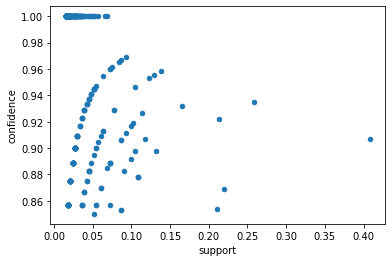

In [ ]:
# Gráfico de dispersión de soporte de las reglas (eje X) frente a confianza (eje Y)
reglas_asociacion.plot.scatter('support', 'confidence')
plt.show()

Lo que nos resulta interesante o lo que no, puede variar según cual sea nuestro objetivo. Así, si estuviéramos interesados en descubrir subgrupos de pacientes muy minoritarios pero en los que siempre se cumplen ciertas condiciones nos podría interesar prestar especial atención a ese grupo de reglas de la esquina superior izquierda del gráfico que tienen confianza 1 pero soportes bajos o muy bajos. 

Las reglas con los soportes más altos tienen que estar formadas por itemsets bastante frecuentes en el conjunto de datos y probablemente establezcan relaciones muy generales que puede que no aporten demasiado valor. En el grueso de reglas que tienen soportes medios o bajos es probable que existan reglas interesantes puesto que representan asociaciones que son difíciles de detectar a simple vista pero que se dan en una cantidad de pacientes lo suficientemente representativa como para que nos sea interesante analizarlas.


Existen distintos tipos de visualizaciones en los que nos podemos apoyar para estudiar las reglas y que nos pueden ayudar bastante a resumir la información y hacernos una primera idea de qué nos están diciendo las reglas de un solo vistazo. Un ejemplo sería el gráfico de tipo "categorías paralelas" que vamos a generar a continuación.

In [ ]:
# Para poder generar el gráfico vamos a convertir los elementos de las columnas
# 'antecedents' y 'consequents' de frozensets a listas
reglas_asociacion['antecedents'] = reglas_asociacion['antecedents'].apply(lambda x: list(x))
reglas_asociacion['consequents'] = reglas_asociacion['consequents'].apply(lambda x: list(x))

print()

In [ ]:
# Generamos un gráfico estilo parallel categories

# Importamos las bibliotecas necesarias
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Creamos la paleta de colores a usar
colores_px = px.colors.qualitative.Pastel1+px.colors.qualitative.Pastel
# Listamos todos los ítems presentes en el conjunto de datos
lista_items = np.array(transacciones.columns)

lista_auxiliar = []
colores = []
for indice,regla in reglas_asociacion.iterrows():
  for ant_item in regla['antecedents']:
    consecuente = regla['consequents'][0]
    lista_auxiliar.append([ant_item, consecuente])
    colores.append(colores_px[np.where(lista_items == consecuente)[0][0]])

df_auxiliar = pd.DataFrame(lista_auxiliar, columns=['Antecedente', 'Consecuente'])

# Creamos una dimensión del gráfico para antecedentes
antecedent_dim = go.parcats.Dimension(
    values=df_auxiliar.Antecedente,
    label="Antecedente"
)

# Y otra para consecuentes
consequent_dim = go.parcats.Dimension(
    values=df_auxiliar.Consecuente,
    label="Consecuente"
)

# Creamos la figura configurando algunos parámetros del aspecto del gráfico
fig = go.Figure(data = [go.Parcats(dimensions=[antecedent_dim, consequent_dim],
        hoveron='category', hoverinfo='count',
        line={'color':colores},
        labelfont={'size': 14, 'family': 'Arial'},
        arrangement='freeform')])

# Indicamos el tipo y tamaño de letra, y los márgenes de la figura 
fig.update_layout(
    font=dict(
        family="Arial, monospace",
        size=12,
        color="#7f7f7f"
    ),
    margin=dict(l=200, r=200, t=20, b=20)
)

# Mostramos la figura
fig.show()


En este gráfico tenemos a la izquierda los ítems que aparecen en el antecedente de alguna regla y a la derecha los ítems que aparecen en algún consecuente:
* Cuanto mayor sea el número de reglas en el que aparece el ítem como antecedente o consecuente (según corresponda) más grande será el sector de la barra izda o dcha asociado a dicho ítem.

* Si un ítem A aparece alguna vez como parte del antecedente de una regla en cuyo consecuente aparece el ítem B, se dibuja una línea que irá desde A en la izda a B en la dcha del gráfico. El grosor de dicha línea nos indica el nº de reglas en las que aparecen simultáneamente el ítem de la izquierda como parte del antecedente y el de la derecha como parte del consecuente.

Se trata de un gráfico interactivo así que podemos, entre otras cosas, poner nuestro ratón sobre las distintas líneas y ver el número exacto de reglas en las que se relacionan dos ítems. También podemos ponernos sobre un ítem concreto en la columna de antecedente o consecuente y se destacará sólo la parte del gráfico relacionada con las apariciones de dicho ítem como antecedente o consecuente.

Gráficos como este nos permiten resumir mucha información y ver con facilidad, por ejemplo, esa predominancia que hemos comentado anteriormente del ítem 'UV-signature=UV signature' en los consecuentes de las reglas. Como hemos visto se trata de un ítem con un soporte muy alto y, por tanto, se pueden obtener reglas con una confianza elevada casi con cualquier antecedente.

Poner el foco en otros grupos de reglas que consiguen altos valores de confianza con consecuentes más específicos, reglas que nos señalan condiciones que solo se cumplen en ciertos pacientes, puede ser mucho más interesante. Así, a continuación nos vamos a centrar en reglas que intentan explicar qué tienen en común los pacientes que presentan un tipo concreto de mutación, aunque este es sólo un ejemplo de uno de los múltiples análisis que se podrían llevar a cabo.

###**4.3 Análisis por grupos**

Comentábamos al principio de la cápsula que la detección de distintos tipos de mutaciones ha permitido el desarrollo de terapias dirigidas en función de la mutación encontrada. 
Un tipo de enfoque que se suele utilizar en el análisis de reglas de asociación es el "análisis por grupos". En este tipo de análisis, dividimos las reglas en distintos grupos en función, por ejemplo, de si contienen o no ciertas variables.
Así, podríamos quedarnos con aquellas reglas en cuyo consecuente aparece la variable MUTATIONSUBTYPES y distinguir entre aquellas en las que el consecuente se refiere a mutaciones BRAF_Hotspot_Mutants y aquellas en las que se refiere a RAS_Hotspot_Mutants. 

De nuevo, podemos apoyarnos en herramientas de visualización que nos permitan resumir el conocimiento contenido en las reglas y representarlo de forma gráfica. En este caso vamos a utilizar un diagrama de Chord (Chord diagram), también conocido como rueda de dependencia. 
Para generar el Chord diagram vamos a utilizar la biblioteca *chorddiag* de R. Al tratarse de una biblioteca de R y no de Python necesitamos, al igual que en cápsulas anteriores, usar la biblioteca *rpy2* (que se instala al inicio del notebook).

Para poder generar una rueda de dependencia o Chord diagram primero necesitamos crear una matriz de adyacencia. Se trata de una matriz cuadrada con tantas filas y columnas como ítems en la que se indica para cada par de ítems el número de reglas en las que el primer ítem está en el antecedente y el segundo en el consecuente. En la siguiente celda puedes encontrar el código para generar la matriz de adyacencia correspondiente a las reglas en cuyo consecuente aparecen los subtipos de mutación BRAF o RAS.

In [ ]:
# Importamos la biblioteca numpy bajo el alias np
import numpy as np

# Vamos a listar aquellos ítems que aparecen en el antecedente o consecuente
# de los grupos de reglas que nos interesan 
lista_items = []

# Para cada regla cuyo consecuente está formado por el ítem 'MUTATIONSUBTYPES=RAS_Hotspot_Mutants'
# o 'MUTATIONSUBTYPES=BRAF_Hotspot_Mutants' añadimos a lista_items los ítems de 
# su antecedente y de su consecuente
for indice, regla in reglas_asociacion.iterrows():
  if ('MUTATIONSUBTYPES=RAS_Hotspot_Mutants' in regla['consequents'] or 'MUTATIONSUBTYPES=BRAF_Hotspot_Mutants' in regla['consequents']) and len(regla['consequents']) == 1:
    for con in regla['consequents']: # Para cada ítem del consecuente
      if con not in lista_items: # Si no lo habíamos añadido previamente
        lista_items.append(con) # Lo añadimos a lista_items

    for ant in regla['antecedents']: # Para cada ítem del antecedente
      if ant not in lista_items: # Si no lo habíamos añadido previamente
        lista_items.append(ant) # Lo añadimos a lista_items

lista_items = np.array(lista_items)

# Creamos la matriz de adyacencia y la inicializamos a cero
matriz_adyacencia_porgrupos = np.zeros((len(lista_items), len(lista_items)), dtype=int)

# Recorremos las reglas 
for indice, regla in reglas_asociacion.iterrows():
  # Si el consecuente lo forma uno de los dos ítems que nos interesan
  if ('MUTATIONSUBTYPES=RAS_Hotspot_Mutants' in regla['consequents'] or 'MUTATIONSUBTYPES=BRAF_Hotspot_Mutants' in regla['consequents']) and len(regla['consequents']) == 1:
    # Para cada ítem del consecuente (en nuestro caso solo hay una)
    for con in regla['consequents']:
      # Localizamos su posición en lista_items
      pos_consecuente = np.where(lista_items==con)[0][0]
      # Para cada ítem del antecedente de la regla
      for ant in regla['antecedents']:
        # Localizamos su posición en lista_items
        pos_antecedente = np.where(lista_items==ant)[0][0]
        # Sumamos uno a la posición de la matriz localizada en la fila 
        # correspondiente al ítem del consecuente y la columna correspondiente
        # al ítem del antecedente
        # De esta forma indicamos que hemos encontrado una regla más en la que
        # ambos ítems aparecen juntos, uno en el antecedente y otro en el consecuente
        matriz_adyacencia_porgrupos[pos_consecuente, pos_antecedente] += 1




Una vez que hemos generado la matriz de adyacencia podemos usar R para crear nuestro Chord Diagram a partir de dicha matriz.
Recordamos que las celdas que comienzan con %%R son celdas que contienen código de R.

In [ ]:
%%R -i matriz_adyacencia_porgrupos -i lista_items

library(chorddiag)

dimnames(matriz_adyacencia_porgrupos) <- list(consecuente = lista_items, antecedente = lista_items)

# Build the chord diagram:
p <- chorddiag(matriz_adyacencia_porgrupos, margin = 250, width=1000, height=1000, palette='Spectral', groupnamePadding = 20, groupnameFontsize = 10, showTicks=FALSE)

# save the widget
library(htmlwidgets)
saveWidget(p, file="chordDiagram_porgrupos.html")

Con este código en R hemos creado un Chord diagram que se ha almacenado en el archivo 'chordDiagram_porgrupos.html'. Podemos descargar el archivo ejecutando la siguiente celda. Una vez descargado, podremos abrirlo en nuestro navegador e interactuar con él.

In [ ]:
from google.colab import files
files.download('chordDiagram_porgrupos.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Si abres en tu navegador el archivo descargado verás un gráfico como el que se muestra a continuación. 
Sin embargo, el gráfico que visualizamos aquí es solo una copia del que hemos generado (y descargado en nuestro ordenador) al ejecutar el notebook. Esto significa que si cambiamos el código del notebook el archivo que podemos descargar puede cambiar pero el que mostramos a continuación no, porque solo es una copia hecha previamente.

Los distintos sectores en los que está dividida la circunferencia de la rueda representan las apariciones de cada ítem en los consecuentes de las reglas. Cuánto mayor sea la longitud del sector reservado para un ítem mayor será el número de reglas en cuyo consecuente aparece. Aquellos ítems que no aparecen en ningún consecuente están representados por una fina línea.

Cada uno de estos sectores está dividido en diferentes subsectores que enlazan con los diferentes ítems que aparecen en los antecedentes. Es decir, en el Chord diagram vemos que dentro del sector correspondiente a 'MUTATIONSUBTYPES=RAS_Hotspot_Mutants' hay un subsector que enlaza con el ítem 'LYMPHOCYTE.SCORE=0.0' porque 'LYMPHOCYTE.SCORE=0.0' aparece en el antecedente de reglas que tienen en su consecuente 'MUTATIONSUBTYPES=RAS_Hotspot_Mutants'. El grosor del subsector es proporcional al número de reglas en las que se da esta relación. En este caso de las 6 reglas con 'MUTATIONSUBTYPES=RAS_Hotspot_Mutants' en el consecuente, 2 reglas incluían 'LYMPHOCYTE.SCORE=0.0' en su antecedente.

In [ ]:
from IPython.display import HTML, IFrame
IFrame(src='https://sl.ugr.es/chordDiagram',width=1000, height=500)

Una vez que sabemos cómo interpretarlo, el Chord diagram nos ofrece de un vistazo bastante información sobre nuestros subgrupos de reglas. Por ejemplo, poniendo nuestro ratón sobre uno y otro tipo de mutación es fácil detectar que sólo hay dos ítems que aparecen en el antecedente de ambos tipos de mutaciones: 'LYMPHOCYTE.SCORE=0.0' y 'MIRCluster=MIR.type.4'. El resto de los ítems se relacionan únicamente con submutaciones tipo BRAF o tipo RAS, pero no con ambas.
También resulta sencillo ver que el ítem que más veces aparece como antecedente para el tipo de mutación BRAF es 'RNASEQ-CLUSTER_CONSENHIER=MITF-low' lo que apunta a un vínculo importante entre la pertenencia al clúster MITF-low y presentar mutaciones tipo BRAF.

Además, puesto que el nº de reglas incluidas en cada grupo es pequeño, podemos permitirnos ver en detalle las reglas y profundizar en el estudio de las diferencias entre la relación de ambos tipos de mutaciones con el resto de variables.

Vamos a mostrar primero cada una de las reglas con consecuente (MUTATIONSUBTYPES=RAS_Hotspot_Mutants):



In [ ]:
# Hacemos algunos ajustes para que al mostrar reglas concretas su formato sea más amigable
# Ordenamos los items de antecedentes y consecuentes en orden alfabético
reglas_asociacion['antecedents'].apply(lambda x: x.sort(reverse=False))
reglas_asociacion['consequents'].apply(lambda x: x.sort(reverse=False))

print()

In [ ]:
# Obtener los índices de las reglas en cuyo consecuente aparece MUTATIONSUBTYPES=RAS_Hotspot_Mutants
indices_consecuente_RASmut = reglas_asociacion['consequents'].apply(lambda x: 'MUTATIONSUBTYPES=RAS_Hotspot_Mutants' in x and len(x) == 1)
# Seleccionar solo aquellas reglas en cuyo consecuente aparece MUTATIONSUBTYPES=RAS_Hotspot_Mutants
reglas_consecuente_RASmut = reglas_asociacion.loc[indices_consecuente_RASmut, reglas_asociacion.columns].reset_index()
print('Nº de reglas con (MUTATIONSUBTYPES=RAS_Hotspot_Mutants) como consecuente: %d' % (len(reglas_consecuente_RASmut)))

# Obtener los índices de las reglas en cuyo consecuente aparece MUTATIONSUBTYPES=BRAF_Hotspot_Mutants
indices_consecuente_BRAFmut = reglas_asociacion['consequents'].apply(lambda x: 'MUTATIONSUBTYPES=BRAF_Hotspot_Mutants' in x and len(x) == 1)
# Seleccionar solo aquellas reglas en cuyo consecuente aparece MUTATIONSUBTYPES=BRAF_Hotspot_Mutants
reglas_consecuente_BRAFmut = reglas_asociacion.loc[indices_consecuente_BRAFmut, reglas_asociacion.columns].reset_index()
print('Nº de reglas con (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants) como consecuente: %d' % (len(reglas_consecuente_BRAFmut)))

Nº de reglas con (MUTATIONSUBTYPES=RAS_Hotspot_Mutants) como consecuente: 2
Nº de reglas con (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants) como consecuente: 5


In [ ]:
print('>>> Reglas con (MUTATIONSUBTYPES=RAS_Hotspot_Mutants) como consecuente <<<')
print()
for indice, regla in reglas_consecuente_RASmut.iterrows():
  print('REGLA %d' %(indice+1))
  print(regla['antecedents'], ' -----> ', regla['consequents'])
  print('Soporte del consecuente: %f' % regla['consequent support'])
  print('Soporte de la regla: %f' % regla['support'])
  print('Confianza: %f' % regla['confidence'])
  print('Lift: %f ' % regla['lift'])
  print('Leverage: %f' % regla['leverage'])
  print()

>>> Reglas con (MUTATIONSUBTYPES=RAS_Hotspot_Mutants) como consecuente <<<

REGLA 1
['LYMPHOCYTE.SCORE=0.0', 'MethTypes.201408=CpG island-methylated', 'RNASEQ-CLUSTER_CONSENHIER=immune']  ----->  ['MUTATIONSUBTYPES=RAS_Hotspot_Mutants']
Soporte del consecuente: 0.276276
Soporte de la regla: 0.021021
Confianza: 1.000000
Lift: 3.619565 
Leverage: 0.015213

REGLA 2
['LYMPHOCYTE.SCORE=0.0', 'MIRCluster=MIR.type.4', 'MethTypes.201408=CpG island-methylated']  ----->  ['MUTATIONSUBTYPES=RAS_Hotspot_Mutants']
Soporte del consecuente: 0.276276
Soporte de la regla: 0.018018
Confianza: 0.857143
Lift: 3.102484 
Leverage: 0.012210



Ambas reglas comparten, además del consecuente, dos de los tres ítems que forman el antecedente 'LYMPHOCYTE.SCORE=0.0' y 'MethTypes.201408=CpG island-methylated'. La diferencia entre ambas reglas está en el uso de la variable 'RNASEQ-CLUSTER_CONSENHIER' o de la variable 'MIRCluster'. Puesto que, teniendo ambas el mismo consecuente, es la REGLA 1 la que presenta mayor confianza, mayor lift y mayor leverage parece que en este caso el clustering realizado para obtener la variable 'RNASEQ-CLUSTER_COSENHIER' ha resultado de mayor utilidad para encontrar un patrón fiable relacionado con la mutación RAS hot-spot.

La REGLA 1 tiene un soporte relativamente bajo, lo que supone que está caracterizando a un número pequeño de pacientes (2.1% del conjunto de datos) pero ofrece una confianza de 1 lo que permite que haya pacientes en el conjunto de datos para los que conocidos los valores de otras 3 variables sepamos qué tipo de mutación tienen. Este grupo de pacientes supone, además, cerca del 8% del total de pacientes que presentan mutación de tipo RAS, el segundo tipo de mutación más común encontrado en los datos. Por supuesto, para poder extender esta regla más allá de nuestro conjunto de datos sería necesario realizar una validación externa en distintos conjuntos de pacientes para confirmar que esta asociación se cumple también en otras poblaciones.

Pasamos ahora a las reglas con consecuente (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants):

In [ ]:
print('>>> Reglas con (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants) como consecuente <<<')
print()
for indice, regla in reglas_consecuente_BRAFmut.iterrows():
  print('REGLA %d' %(indice+1))
  print(regla['antecedents'], ' -----> ', regla['consequents'])
  print('Soporte del consecuente: %f' % regla['consequent support'])
  print('Soporte de la regla: %f' % regla['support'])
  print('Confianza: %f' % regla['confidence'])
  print('Lift: %f ' % regla['lift'])
  print('Leverage: %f' % regla['leverage'])
  print()

>>> Reglas con (MUTATIONSUBTYPES=BRAF_Hotspot_Mutants) como consecuente <<<

REGLA 1
['LYMPHOCYTE.SCORE=0.0', 'MethTypes.201408=hypo-methylated', 'RNASEQ-CLUSTER_CONSENHIER=MITF-low']  ----->  ['MUTATIONSUBTYPES=BRAF_Hotspot_Mutants']
Soporte del consecuente: 0.450450
Soporte de la regla: 0.018018
Confianza: 1.000000
Lift: 2.220000 
Leverage: 0.009902

REGLA 2
['MIRCluster=MIR.type.1', 'RNASEQ-CLUSTER_CONSENHIER=MITF-low']  ----->  ['MUTATIONSUBTYPES=BRAF_Hotspot_Mutants']
Soporte del consecuente: 0.450450
Soporte de la regla: 0.036036
Confianza: 0.857143
Lift: 1.902857 
Leverage: 0.017098

REGLA 3
['MIRCluster=MIR.type.1', 'MethTypes.201408=hypo-methylated', 'RNASEQ-CLUSTER_CONSENHIER=MITF-low']  ----->  ['MUTATIONSUBTYPES=BRAF_Hotspot_Mutants']
Soporte del consecuente: 0.450450
Soporte de la regla: 0.021021
Confianza: 1.000000
Lift: 2.220000 
Leverage: 0.011552

REGLA 4
['MIRCluster=MIR.type.4', 'MethTypes.201408=hyper-methylated', 'RNASEQ-CLUSTER_CONSENHIER=MITF-low']  ----->  ['MUT

Todas las reglas con 'MUTATIONSUBTYPES=BRAF_Hotspot_Mutants' en el consecuente tienen en común la presencia de 'RNASEQ-CLUSTER_CONSENHIER=MITF-low' en el antecedente. 
A grandes rasgos podemos decir que además de con el cluster MITF-low, las mutaciones BRAF hot-spot también parecen relacionarse con los clusters de metilación hyper-methylated e hypo-methylated, con los MIRClusters de tipo 1 y de tipo 4 y con valores bajos para los linfocitos.

La REGLA 2 es la más general, tiene el soporte más alto y solo dos variables en el antecedente pero también es la que ofrece un valor de confianza más bajo. Las otras 4 reglas incluyen la variable MethTypes.201408 en sus antecedentes y ofrecen valores más altos de confianza. De hecho, la única diferencia entre la REGLA 2 y la REGLA 3 es que esta última incorpora el ítem 'MethTypes.201408=hypo-methylated' lo que le permite alcanzar una confianza de 1, frente al 0,857 de la REGLA 2. Por lo tanto, tener en cuenta si la instancia pertenece al cluster hypo-methylated permite identificar con mayor fiabilidad a un subgrupo de pacientes que va a presentar mutaciones de tipo BRAF.
Si seguimos atendiendo a la variable MethTypes.201408 podemos distinguir, por un lado, las reglas 1 y 3 en las que aparece el clúster hypo-methylated y, por otro, las reglas 4 y 5 en las que aparece el clúster hyper-methylated. Dependiendo de la regla dentro de cada subgrupo aparece la variable LYMPHOCYTE.SCORE o la variable MIRCluster. Al igual que ocurría con la metilación ('MethTypes.201408'), parece que el clustering de microRNA facilita identificar con mayor certidumbre a un subgrupo concreto de pacientes que presentan mutaciones tipo BRAF.
Esto apunta a dos subgrupos de pacientes con mutaciones tipos BRAF, pertenecientes al cluster MITF-low y con niveles bajos de linfocitos: 
* Pacientes para los que se observan valores de metilación bajos y que se relacionan con el MIRCluster MIR.type.1
* Pacientes para los que se observan valores de metilación altos y que se relacionan con el MIRCluster MIR.type.4

Estos resultados parecen corroborar que las agrupaciones que se realizaron en los distintos análisis de clustering permiten distinguir de forma fiable distintos perfiles de pacientes. 

###**4.4 ¿Y ahora qué?**


Este es solo un ejemplo del tipo de análsis basado en reglas de asociación que se puede realizar en un problema como el del conjunto de datos de melanoma con el que estamos trabajando en este curso. Dependiendo de cual sea nuestro objetivo puede interesarnos centrarnos más en unos u otros subconjuntos de reglas o simplemente tener una visión más general de como se relacionan las distintas variables de nuestro conjunto de datos.

Te animamos a que pruebes a explorar otros subconjuntos de reglas que nos dan información sobre diferentes subtipos de pacientes de melanoma. Poder detectar distintos perfiles de pacientes y caracterizarlos ayuda a entender por qué los pacientes presentan distintos pronósticos o reaccionan de forma distinta a tratamientos, y permite ser más eficaz a la hora de escoger el mejor tratamiento para cada tipo de paciente.

## **REFERENCIAS BIBLIOGRÁFICAS**


*   Documentación biblioteca Pandas: https://pandas.pydata.org/docs/getting_started/overview.html
*   Documentación y código biblioteca MLXTEND: http://rasbt.github.io/mlxtend/
*   Documentación biblioteca Matplotlib: https://matplotlib.org/contents.html
*   Usando rpy2 en notebooks: https://rpy2.github.io/doc/latest/html/notebooks.html 
*   Documentación de Plotly Express: https://plotly.com/python/plotly-express/



<div class="alert alert-block alert-success">

MOOC Machine Learning y Big Data para la Bioinformática (1ª edición)   
http://abierta.ugr.es     
    
</div>    